In [ ]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import os

extract_path = "./archive"

for root, dirs, files in os.walk(extract_path):
    print(root, "->", len(files), "files")


./archive -> 0 files
./archive\fold_0 -> 0 files
./archive\fold_0\all -> 2397 files
./archive\fold_0\hem -> 1130 files
./archive\fold_1 -> 0 files
./archive\fold_1\all -> 2418 files
./archive\fold_1\hem -> 1163 files
./archive\fold_2 -> 0 files
./archive\fold_2\all -> 2457 files
./archive\fold_2\hem -> 1096 files


In [3]:
import os

# Local dataset base path (change if your folder is elsewhere)
dataset_path = "./archive"

print("Root of Local Project Folder:")
print(os.listdir("."))  # To see files/folders at current directory

print("\nDataset path exists:", os.path.exists(dataset_path))

if os.path.exists(dataset_path):
    print("\nFirst level folders inside archive:")
    print(os.listdir(dataset_path))

    fold0_path = os.path.join(dataset_path, "fold_0")
    print("\nFold_0 path exists:", os.path.exists(fold0_path))

    if os.path.exists(fold0_path):
        print("Contents inside fold_0:")
        print(os.listdir(fold0_path))

        all_path = os.path.join(fold0_path, "all")  # lowercase as per your image
        hem_path = os.path.join(fold0_path, "hem")  # lowercase as per your image

        for cls in [all_path, hem_path]:
            if os.path.exists(cls):
                files = os.listdir(cls)
                print(f"\nFolder: {cls}")
                print(f"Number of files: {len(files)}")
                print("First 5 files:", files[:5])
            else:
                print(f"\nFolder does not exist: {cls}")

Root of Local Project Folder:
['.git', 'archive', 'Confusion.pdf', 'PixelForge.ipynb', 'PixelForge1.ipynb', 'PixelForge2.ipynb', 'PixelForge_Debug', 'README.md', 'Roc.pdf']

Dataset path exists: True

First level folders inside archive:
['fold_0', 'fold_1', 'fold_2']

Fold_0 path exists: True
Contents inside fold_0:
['all', 'hem']

Folder: ./archive\fold_0\all
Number of files: 2397
First 5 files: ['UID_11_10_1_all.bmp', 'UID_11_11_1_all.bmp', 'UID_11_11_2_all.bmp', 'UID_11_11_3_all.bmp', 'UID_11_12_1_all.bmp']

Folder: ./archive\fold_0\hem
Number of files: 1130
First 5 files: ['UID_H11_10_1_hem.bmp', 'UID_H11_10_2_hem.bmp', 'UID_H11_10_3_hem.bmp', 'UID_H11_11_1_hem.bmp', 'UID_H11_11_2_hem.bmp']


In [4]:
import os, glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch

# 1️⃣ Custom Dataset
class LeukemiaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.all_images = []
        self.labels = []
        self.transform = transform

        # Map class names (case-insensitive) to labels
        class_map = {"hem": 0, "all": 1}

        for folder in os.listdir(root_dir):
            folder_lower = folder.lower()
            if folder_lower in class_map:
                label = class_map[folder_lower]
                class_path = os.path.join(root_dir, folder)

                # Accept all common image extensions
                for img_file in glob.glob(os.path.join(class_path, "*.*")):
                    self.all_images.append(img_file)
                    self.labels.append(label)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path = self.all_images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

# 2️⃣ Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # resize to 128x128
    transforms.ToTensor(),           # convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)) # normalize
])

# 3️⃣ Create dataset + dataloader
dataset_path = "./archive/fold_0"
train_dataset = LeukemiaDataset(dataset_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 4️⃣ Check dataset
print("Total images found:", len(train_dataset))
print("First 10 labels:", [train_dataset[i][1] for i in range(10)])

# 5️⃣ Check one batch
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)  # [32, 3, 128, 128]
print("Batch labels:", labels)


Total images found: 3527
First 10 labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Batch image tensor shape: torch.Size([32, 3, 128, 128])
Batch labels: tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1])


In [5]:
import torch.nn as nn
import torch.optim as optim

# 1️⃣ Define CNN Model
class LeukemiaCNN(nn.Module):
    def __init__(self):
        super(LeukemiaCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),  # 128 feature maps of size 16x16
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # 2 classes: hem(0), all(1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc_layers(x)
        return x

# 2️⃣ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LeukemiaCNN().to(device)

# 3️⃣ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4️⃣ Training Loop
epochs = 5  # start small
for epoch in range(epochs):
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward + Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100 * correct/total:.2f}%")


Using device: cuda
Epoch [1/5], Loss: 0.5509, Accuracy: 74.14%
Epoch [2/5], Loss: 0.4520, Accuracy: 81.20%
Epoch [3/5], Loss: 0.4382, Accuracy: 82.22%
Epoch [4/5], Loss: 0.4206, Accuracy: 82.79%
Epoch [5/5], Loss: 0.4108, Accuracy: 83.27%


In [6]:
from torch.utils.data import random_split

# Split dataset: 80% train, 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_set)}, Validation samples: {len(val_set)}")


Training samples: 2821, Validation samples: 706


In [7]:
epochs = 5
for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/5] Train Loss: 0.3942, Train Acc: 84.47% | Val Loss: 0.4075, Val Acc: 83.99%
Epoch [2/5] Train Loss: 0.3879, Train Acc: 84.86% | Val Loss: 0.4269, Val Acc: 83.85%
Epoch [3/5] Train Loss: 0.3742, Train Acc: 86.07% | Val Loss: 0.4028, Val Acc: 85.27%
Epoch [4/5] Train Loss: 0.3643, Train Acc: 85.54% | Val Loss: 0.5037, Val Acc: 80.59%
Epoch [5/5] Train Loss: 0.3610, Train Acc: 85.57% | Val Loss: 0.3767, Val Acc: 84.99%


In [8]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device, class_names, save_roc_path=None):
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs[:, 1].cpu().numpy())  # for binary ROC

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)

    # ROC Curve & AUC (for binary classification)
    if len(class_names) == 2:
        auc = roc_auc_score(y_true, y_probs)
        print(f"\nROC-AUC Score: {auc:.4f}")

        fpr, tpr, _ = roc_curve(y_true, y_probs)
        fig = plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        fig.savefig("Roc.pdf", dpi=300, bbox_inches='tight')  # Save ROC plot as PDF
        plt.show()



Classification Report:

              precision    recall  f1-score   support

      Normal       0.84      0.68      0.75       237
    Leukemia       0.85      0.93      0.89       469

    accuracy                           0.85       706
   macro avg       0.85      0.81      0.82       706
weighted avg       0.85      0.85      0.85       706


Confusion Matrix:
 [[162  75]
 [ 31 438]]

ROC-AUC Score: 0.8851


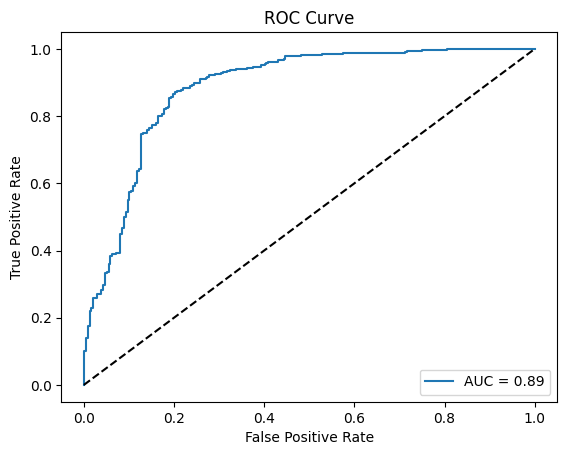

In [9]:
class_names = ["Normal", "Leukemia"]  # change based on your dataset
evaluate_model(model, val_loader, device, class_names)


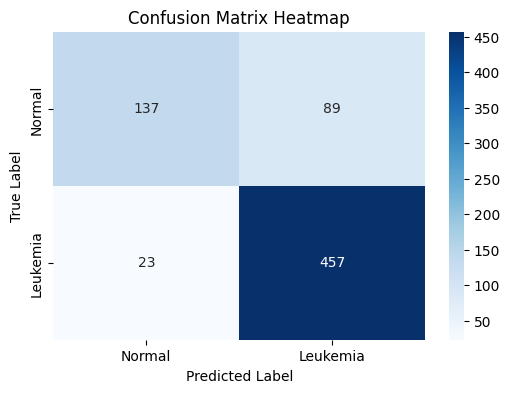

In [10]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_confusion_matrix(cm, class_names):
#     plt.figure(figsize=(6,4))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=class_names, yticklabels=class_names)
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.title('Confusion Matrix Heatmap')
#     plt.show()

# # Call it after evaluation
# plot_confusion_matrix([[137, 89], [23, 457]], ["Normal", "Leukemia"])

import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names, save_path=None):
    fig = plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix Heatmap')
    if save_path:
        fig.savefig("lr_shap_1.pdf", dpi=300, bbox_inches='tight')  # Save the figure as a PDF
    plt.show()

# Example usage saving as PDF
plot_confusion_matrix([[137, 89], [23, 457]], ["Normal", "Leukemia"], save_path="confusion_matrix.pdf")


In [13]:
import torch, sys, os, inspect
print("Python executable:", sys.executable)
print("Torch:", torch.__file__)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("CUDA version:", torch.version.cuda)
        print("Current device:", torch.cuda.current_device())
        print("Device name:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("CUDA query failed:", e)
print("KERNEL: globals keys (showing relevant names):", [k for k in globals().keys() if 'G' in k or 'D' in k or 'train' in k][:50])


Python executable: C:\Users\kumud\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe
Torch: C:\Users\kumud\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\__init__.py
Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Current device: 0
Device name: NVIDIA GeForce RTX 4050 Laptop GPU
KERNEL: globals keys (showing relevant names): ['Dataset', 'DataLoader', 'LeukemiaDataset', 'train_dataset', 'train_loader', 'train_size', 'train_set', 'train_acc', 'train_loss']


In [14]:
import os, glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class RecursiveImageDataset(Dataset):
    """Recursively collects image files in `root` (common extensions) and returns transformed tensors."""
    def __init__(self, root, transform):
        exts = ["*.bmp", "*.png", "*.jpg", "*.jpeg", "*.BMP", "*.PNG", "*.JPG", "*.JPEG"]
        self.files = []
        for e in exts:
            self.files += glob.glob(os.path.join(root, "**", e), recursive=True)
        self.files = sorted(self.files)
        self.transform = transform
        print(f"[Dataset] Found {len(self.files)} images in {root}")

    def __len__(self): 
        return len(self.files)
    
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        return self.transform(img)


In [15]:
import torch
import torch.nn as nn

class PixelNorm(nn.Module):
    def forward(self, x, eps=1e-8):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + eps)

class GenBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class PixelForgeGenerator(nn.Module):
    def __init__(self, z_dim=100, base_ch=64, out_ch=3):
        super().__init__()
        self.z_dim = z_dim
        self.pixelnorm = PixelNorm()
        self.project = nn.Sequential(
            nn.ConvTranspose2d(z_dim, base_ch*8, 4, 1, 0),
            nn.BatchNorm2d(base_ch*8),
            nn.ReLU(True)
        )
        self.up1 = GenBlock(base_ch*8, base_ch*4)
        self.up2 = GenBlock(base_ch*4, base_ch*2)
        self.up3 = GenBlock(base_ch*2, base_ch)
        self.up4 = GenBlock(base_ch, base_ch//2)
        self.up5 = GenBlock(base_ch//2, base_ch//4)
        self.to_rgb = nn.Sequential(
            nn.Conv2d(base_ch//4, out_ch, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.pixelnorm(z)
        x = self.project(z)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.up5(x)
        return self.to_rgb(x)


In [16]:
import torch.nn.functional as F

def d_hinge_loss(real_out, fake_out):
    loss_real = torch.mean(F.relu(1.0 - real_out))
    loss_fake = torch.mean(F.relu(1.0 + fake_out))
    return loss_real + loss_fake

def g_hinge_loss(fake_out):
    return -torch.mean(fake_out)


In [17]:
import time, traceback
from torchvision.utils import save_image
from datetime import timedelta
import os, time, torch
from torchvision.utils import save_image
from tqdm import tqdm  # for progress bar
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


# ---------- Modified SNConv and Discriminator (returns single scalar per sample) ----------
def SNConv(in_c, out_c, k=4, s=2, p=1):
    return nn.utils.spectral_norm(nn.Conv2d(in_c, out_c, k, s, p))

class PixelForgeDiscriminator(nn.Module):
    def __init__(self, in_ch=3, base_ch=64):
        super().__init__()
        # feature trunk
        self.features = nn.Sequential(
            SNConv(in_ch, base_ch), nn.LeakyReLU(0.2, inplace=True),
            SNConv(base_ch, base_ch*2), nn.LeakyReLU(0.2, inplace=True),
            SNConv(base_ch*2, base_ch*4), nn.LeakyReLU(0.2, inplace=True),
            SNConv(base_ch*4, base_ch*8), nn.LeakyReLU(0.2, inplace=True),
        )
        # final conv -> keep spatial then adaptively pool to scalar
        self.final_conv = SNConv(base_ch*8, 1, k=3, s=1, p=1)
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.features(x)
        x = self.final_conv(x)      # (N,1,H,W)
        x = self.pool(x)            # (N,1,1,1)
        return x.view(x.size(0))    # -> (N,)

# ---------- device check helper ----------
def print_module_device(name, module):
    try:
        dev = next(module.parameters()).device
    except StopIteration:
        dev = None
    print(f"{name} device: {dev}")

def ensure_on_device(t, name="tensor"):
    if isinstance(t, torch.Tensor):
        print(f"  {name}.device = {t.device}  dtype={t.dtype}  shape={t.shape}")
        if t.device != device:
            # show stack trace where ensure_on_device was called (helpful)
            print(f"!!! {name} is on {t.device} but expected {device} !!!")
            traceback.print_stack(limit=4)
    else:
        print(f"  {name} is not a tensor (type={type(t)})")

# ---------- instrumented training ----------
def train_pixelforge_gan_instrumented(
        hem_root="./PixelForge_Dataset/fold_0/fold_0",
        out_dir="./pixelforge_debug",   # changed to match your structure
        z_dim=100,
        base_ch=64,
        batch_size=64,
        epochs=100,
        lr=2e-4,
        beta1=0.5,
        save_every=1,
        samples_per_epoch=64):

    import time
    from torchvision.utils import save_image

    # make dirs
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(os.path.join(out_dir, "samples"), exist_ok=True)
    os.makedirs(os.path.join(out_dir, "checkpoints"), exist_ok=True)

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    dataset = RecursiveImageDataset(hem_root, transform)
    if len(dataset) == 0:
        raise RuntimeError(f"No images found in {hem_root}. Check your dataset path!")

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    # instantiate models
    G = PixelForgeGenerator(z_dim=z_dim, base_ch=base_ch).to(device)
    D = PixelForgeDiscriminator(in_ch=3, base_ch=base_ch).to(device)

    print("G id:", id(G), "D id:", id(D))
    print_module_device("Generator G", G)
    print_module_device("Discriminator D", D)

    optG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
    optD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

    fixed_z = torch.randn(samples_per_epoch, z_dim, 1, 1, device=device)
    print("fixed_z.device:", fixed_z.device)

    # quick micro-test
    try:
        G.train(); D.train()
        dummy_real = torch.randn(min(batch_size, 8), 3, 128, 128, device=device)
        dummy_z = torch.randn(min(batch_size, 8), z_dim, 1, 1, device=device)
        torch.cuda.synchronize(); t0 = time.time()
        fake = G(dummy_z)
        out = D(fake)
        loss = g_hinge_loss(out)
        optG.zero_grad(); loss.backward(); optG.step()
        torch.cuda.synchronize(); t1 = time.time()
        print(f"Micro test forward+backward on GPU: {t1-t0:.4f}s")
    except Exception as e:
        print("Micro-test failed:", e)
        traceback.print_exc()

    global_step = 0
    epoch_times = []

    for epoch in range(1, epochs + 1):
        G.train(); D.train()
        d_losses, g_losses = [], []
        t0 = time.time()

        for i, real in enumerate(loader):
            if isinstance(real, (list, tuple)):
                real = real[0]
            real = real.to(device, non_blocking=True)
            b = real.size(0)

            # --- Discriminator update ---
            z = torch.randn(b, z_dim, 1, 1, device=device)
            fake = G(z).detach()
            real_out = D(real)
            fake_out = D(fake)
            lossD = d_hinge_loss(real_out, fake_out)
            optD.zero_grad(); lossD.backward(); optD.step()

            # --- Generator update ---
            z2 = torch.randn(b, z_dim, 1, 1, device=device)
            fake2 = G(z2)
            fake_out2 = D(fake2)
            lossG = g_hinge_loss(fake_out2)
            optG.zero_grad(); lossG.backward(); optG.step()

            d_losses.append(lossD.item())
            g_losses.append(lossG.item())
            global_step += 1

            if (i % 200) == 0:
                print(f"Epoch {epoch} [{i}/{len(loader)}] D_loss={lossD.item():.4f} G_loss={lossG.item():.4f}")

            # quick debug stop
            if i >= 4 and epoch == 1:
                print("Stopping after 5 batches for quick diagnostics.")
                break

        # Epoch done
        epoch_time = time.time() - t0
        epoch_times.append(epoch_time)
        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        remaining_epochs = epochs - epoch
        est_remaining = avg_epoch_time * remaining_epochs

        print(f"Epoch {epoch}/{epochs} done | "
              f"D_loss={sum(d_losses)/len(d_losses):.4f} "
              f"G_loss={sum(g_losses)/len(g_losses):.4f} | "
              f"time={epoch_time:.1f}s | "
              f"⏱️ Estimated time left: {est_remaining/60:.1f} min")

        # --- Save preview images ---
        if epoch % save_every == 0:
            G.eval()
            with torch.no_grad():
                fake_samples = G(fixed_z)
                save_path = os.path.join(out_dir, "samples", f"epoch_{epoch}.png")
                save_image(fake_samples[:1], save_path, normalize=True)
            print(f"🖼️  Saved sample images to: {save_path}")

    # Save final state
    tmpG = os.path.join(out_dir, "G_final.pth.tmp")
    tmpD = os.path.join(out_dir, "D_final.pth.tmp")
    torch.save(G.state_dict(), tmpG); os.replace(tmpG, os.path.join(out_dir, "G_final.pth"))
    torch.save(D.state_dict(), tmpD); os.replace(tmpD, os.path.join(out_dir, "D_final.pth"))
    print("✅ Instrumented training finished and models saved.")
    return G, D

In [18]:
print("device =", device)
print("torch.cuda.is_available() =", torch.cuda.is_available())
print("CUDA device name =", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

G, D = train_pixelforge_gan_instrumented(
    hem_root="./archive/fold_0/hem",
    out_dir="PixelForge_Debug",
    epochs=100,
    batch_size=16
)

device = cuda
torch.cuda.is_available() = True
CUDA device name = NVIDIA GeForce RTX 4050 Laptop GPU
[Dataset] Found 2260 images in ./archive/fold_0/hem
G id: 2675039318720 D id: 2675033027312
Generator G device: cuda:0
Discriminator D device: cuda:0
fixed_z.device: cuda:0
Micro test forward+backward on GPU: 0.8257s
Epoch 1 [0/142] D_loss=2.0829 G_loss=-0.0086
Stopping after 5 batches for quick diagnostics.
Epoch 1/100 done | D_loss=1.1826 G_loss=0.4821 | time=1.0s | ⏱️ Estimated time left: 1.7 min
🖼️  Saved sample images to: PixelForge_Debug\samples\epoch_1.png
Epoch 2 [0/142] D_loss=0.5753 G_loss=1.0493
Epoch 2/100 done | D_loss=0.8775 G_loss=0.9669 | time=17.0s | ⏱️ Estimated time left: 14.8 min
🖼️  Saved sample images to: PixelForge_Debug\samples\epoch_2.png
Epoch 3 [0/142] D_loss=0.9567 G_loss=0.6966
Epoch 3/100 done | D_loss=1.6553 G_loss=0.1811 | time=16.0s | ⏱️ Estimated time left: 18.4 min
🖼️  Saved sample images to: PixelForge_Debug\samples\epoch_3.png
Epoch 4 [0/142] D_loss=